<a href="https://colab.research.google.com/github/ketanpandey01/Bears-Classification/blob/master/Using_Inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


# Get Data

In [0]:
!ls /content/drive/My\ Drive/Colab\ Notebooks/BearClassification/data_gathering_and_processing_up1.py

'/content/drive/My Drive/Colab Notebooks/BearClassification/data_gathering_and_processing_up1.py'


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/BearClassification')

In [0]:
import data_gathering_and_processing_up1 as dg
dg.getData()

TabError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Get Data

In [0]:
import sys
import tarfile
from six.moves import urllib
import os

BEARS_IMAGES_ZIP = "/content/drive/My Drive/Datasets/bear_photos.tar.xz"
BEARS_IMAGES_PATH = os.path.join("/content/drive/My Drive/Colab Notebooks/","datasets", "bears")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_bears(tgz_path=BEARS_IMAGES_ZIP, path=BEARS_IMAGES_PATH):
    if os.path.exists(BEARS_IMAGES_PATH):
      print("Data already loaded")
      return
    os.makedirs(path, exist_ok=True)
    bears_tgz = tarfile.open(tgz_path)
    bears_tgz.extractall(path=path)
    bears_tgz.close()
    #os.remove(tgz_path)

In [3]:
fetch_bears()

Data already loaded


# Data Pre-Processing

## Getting the list of classes

In [4]:
bears_root_path = os.path.join(BEARS_IMAGES_PATH, "bear_photos")
bears_classes = sorted([dirname for dirname in os.listdir(bears_root_path)
                  if os.path.isdir(os.path.join(bears_root_path, dirname))])
bears_classes

['Grizzly', 'Panda', 'Polar']

## Getting the list of all the image file paths for each class

In [0]:
from collections import defaultdict

image_paths = defaultdict(list)

for bear_class in bears_classes:
    image_dir = os.path.join(bears_root_path, bear_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[bear_class].append(os.path.join(image_dir, filepath))

In [6]:
print("No. of images in each class:")
print("Grizzly {}".format(len(image_paths['Grizzly'])))
print("Panda {}".format(len(image_paths['Panda'])))
print("Polar {}".format(len(image_paths['Polar'])))

No. of images in each class:
Grizzly 338
Panda 328
Polar 253


### There are unequal no.of images in each class. Let's make 250 images per class.

In [7]:
import numpy as np

for key,value in image_paths.items():
  image_paths[key] = value[:253]

  
print("No. of images in each class:")
print("Grizzly {}".format(len(image_paths['Grizzly'])))
print("Panda {}".format(len(image_paths['Panda'])))
print("Polar {}".format(len(image_paths['Polar'])))


No. of images in each class:
Grizzly 253
Panda 253
Polar 253


In [0]:
for paths in image_paths.values():
    paths.sort()    

## Look at few images from each class

Class: Grizzly


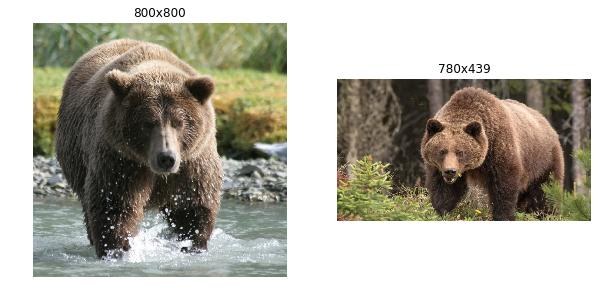

Class: Panda


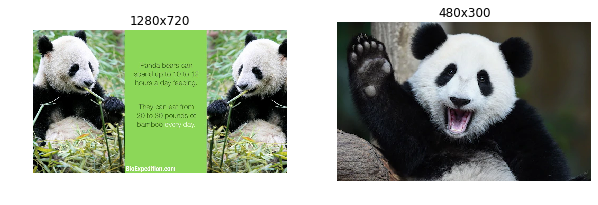

Class: Polar


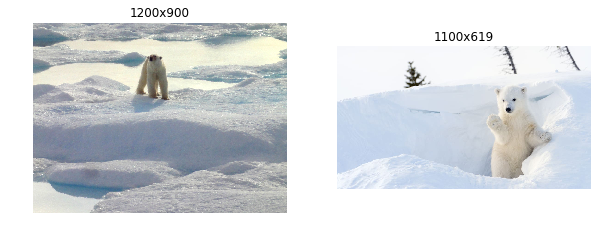

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

n_examples_per_class = 2

for bear_class in bears_classes:
    print("Class:", bear_class)
    plt.figure(figsize=(10,5))
    for index, example_image_path in enumerate(image_paths[bear_class][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :3]
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

## Image Processing
This step that will resize and crop the image to 299 × 299, with some randomness for data augmentation.

In [0]:
from skimage.transform import resize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    # The resize function of scikit-image will automatically transform the image to floats ranging from 0.0 to 1.0
    image = resize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented as 32-bit floats:
    return image.astype(np.float32)

### Image before processing

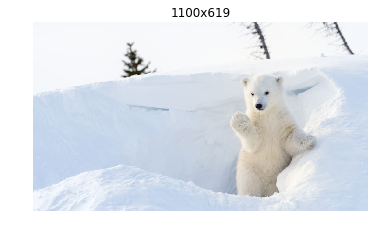

In [11]:
plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

### Image after processing

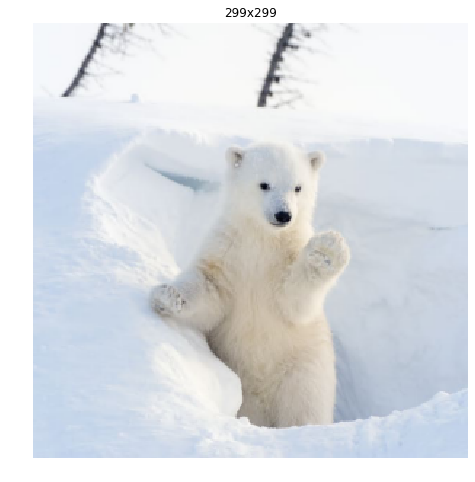

In [12]:
prepared_image = prepare_image(example_image)

plt.figure(figsize=(8, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

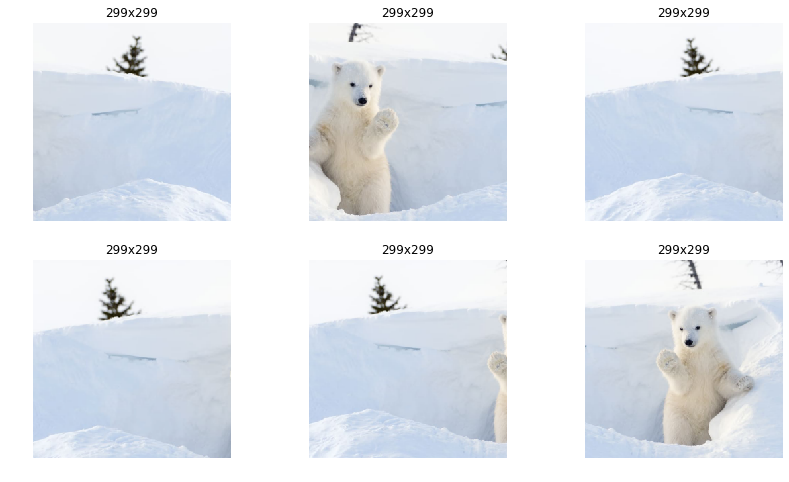

In [13]:
rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

In [14]:
prepared_image.shape

(299, 299, 3)

# Split data into Train and Test set

Convert the classess from string to integers.

In [15]:
bear_class_ids = {bear_class: index for index, bear_class in enumerate(bears_classes)}
bear_class_ids

{'Grizzly': 0, 'Panda': 1, 'Polar': 2}

In [0]:
bear_paths_and_classes = []
for bear_class, paths in image_paths.items():
    for path in paths:
        bear_paths_and_classes.append((path, bear_class_ids[bear_class]))

In [0]:
test_ratio = 0.2
train_size = int(len(bear_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(bear_paths_and_classes)

bear_paths_and_classes_train = bear_paths_and_classes[:train_size]
bear_paths_and_classes_test = bear_paths_and_classes[train_size:]

In [18]:
bear_paths_and_classes_train[:3]

[('/content/drive/My Drive/Colab Notebooks/datasets/bears/bear_photos/Panda/149.realistic-panda-bears-arctic-animals-elizabeths-studio-7211-cotton-crafts-fabric-quilting-sewing-ka-fabrics_122__69821.1561291077.jpg',
  1),
 ('/content/drive/My Drive/Colab Notebooks/datasets/bears/bear_photos/Grizzly/267.grizzly-bear-hero-1.jpg',
  0),
 ('/content/drive/My Drive/Colab Notebooks/datasets/bears/bear_photos/Grizzly/183.Grizzly-Bear-860x614.jpg',
  0)]

In [19]:
len(bear_paths_and_classes_test)

152

In [0]:
from random import sample

def prepare_batch(bear_paths_and_classes, batch_size):
  batch_paths_and_classes = sample(bear_paths_and_classes, batch_size)
  images = [mpimg.imread(path)[:, :, :3] for path, labels in batch_paths_and_classes]
  prepared_images = [prepare_image(image) for image in images]
  X_batch = prepared_images
  y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
  return X_batch, y_batch

In [0]:
X_batch, y_batch = prepare_batch(bear_paths_and_classes_train, batch_size=4)

In [22]:
X_batch[0].shape

(299, 299, 3)

In [23]:
X_batch[0].dtype

dtype('float32')

In [24]:
y_batch.shape

(4,)

In [25]:
y_batch.dtype

dtype('int32')

In [0]:
## Create test set

In [0]:
X_test, y_test = prepare_batch(bear_paths_and_classes_test, batch_size=len(bear_paths_and_classes_test))

In [28]:
len(y_test)

152

# Inception v3

In [0]:
width = 299
height = 299
channels = 3

In [0]:
import tensorflow as tf
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

In [31]:
logits.op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0' shape=(?, 1, 1, 1001) dtype=float32>

In [32]:
logits.op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/Conv2D:0' shape=(?, 1, 1, 1001) dtype=float32>

In [33]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

In [34]:
end_points

{'AuxLogits': <tf.Tensor 'InceptionV3/AuxLogits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'Logits': <tf.Tensor 'InceptionV3/Logits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=floa

In [35]:
end_points["PreLogits"]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

In [0]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

In [37]:
n_outputs = len(bears_classes)

with tf.name_scope("new_output_layer"):
    bear_logits = tf.layers.dense(prelogits, n_outputs, name="bear_logits")
    Y_proba = tf.nn.softmax(bear_logits, name="Y_proba")

W0804 06:03:52.913633 140714881296256 deprecation.py:323] From <ipython-input-37-00a27d240e70>:4: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0804 06:03:52.921758 140714881296256 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=bear_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    bear_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="bear_logits")
    training_op = optimizer.minimize(loss, var_list=bear_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(bear_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 

In [39]:
[v.name for v in bear_vars]

['bear_logits/kernel:0', 'bear_logits/bias:0']

# Train the model

In [0]:
INCEPTION_PATH = os.path.join("/content/drive/My Drive/Colab Notebooks/","datasets","inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

In [41]:
n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(bear_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(bear_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Last batch accuracy:", acc_batch)

        save_path = saver.save(sess, "./my_bears_model")

W0804 06:04:41.006557 140714881296256 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Epoch 0.........

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


......  Last batch accuracy: 1.0
Epoch 1...............  Last batch accuracy: 1.0
Epoch 2...............

IndexError: ignored

In [42]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./my_bears_model")

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Test accuracy:", acc_test)

Computing final accuracy on the test set (this will take a while)...
Test accuracy: 0.9666667
